# Exploring Tweets Related to the COVID-19 Disease

The aim of this project is to explore and analyze data related to the 2019-2020 coronavirus pandemic. We have collected all of the twitter's daily top-tweets, related with coronavirus most common hashtags (313591 tweets). We analyze the most commonly used words and hashtags per week and we implement a sentiment analysis to approximate the percentage of optimistic and pessimistic tweets per week.

## Table of Contents:
#### Data Exploration
* [Import Libraries](#Import-Libraries)
* [Define Useful Functions](#Define-Useful-Functions)
* [Data Collection](#Data-Collection)
* [Amount of Collected Data per Week](#Amount-of-Collected-Data-per-Week)
* [Data Exploration](#Data-Exploration)
* [Most Common Words](#Most-Common-Words)
* [Most Common Words Wordcloud](#Most-Common-Words-Wordcloud)
* [Most Common Hashtags](#Most-Common-Hashtags)
* [Most Common Hashtags Wordcloud](#Most-Common-Hashtags-Wordcloud)
* [Most Common Words per Week](#Most-Common-Words-per-Week)
* [Intersting Words During the Whole Period](#Intersting-Words-During-the-Whole-Period)
* [Interesting Hashtags During the Whole Period](#Interesting-Hashtags-During-the-Whole-Period)

#### Sentiment Analysis
* [Sentiment Analysis](#Sentiment-Analysis)
* [Define Sentiment Analysis Functions](#Define-Sentiment-Analysis-Functions)
* [Import Classification Data](#Import-Classification-Data)
* [Three-way classification model](#Three-way-classification-model)
* [Three-way Data Splitting](#Three-way-Data-Splitting)
* [Three-way Model Selection](#Three-way-Model-Selection)
* [Three-way Model Accuracy](#Three-way-Model-Accuracy)
* [Three-way Model Error Analysis](#Three-way-Model-Error-Analysis)
* [Three-way Model Best Parameters](#Three-way-Model-Best-Parameters)
* [Save Three-way Model](#Save-Three-way-Model)
* [Two-way Classification Model](#Two-way-Classification-Model)
* [Two-way Data Splitting](#Two-way-Data-Splitting)
* [Two-way Model Selection](#Two-way-Model-Selection)
* [Two-way Model Accuracy](#Two-way-Model-Accuracy)
* [Two-way Model Error Analysis](#Two-way-Model-Error-Analysis)
* [Two-way Model Best Parameters](#Two-way-Model-Best-Parameters)
* [Save Two-way Model](#Save-Two-way-Model)
* [Optimism Prediction for Coronavirus Tweets](#Optimism-Prediction-for-Coronavirus-Tweets)
* [Data Classification](#Data-Classification)
* [Three-way Model Classification Results](#Three-way-Model-Classification-Results)
* [Two-way Model Classification Results](#Two-way-Model-Classification-Results)

## Import Libraries

In [1]:
import os
from copy import deepcopy
import csv
import numpy as np
import pandas as pd
from collections import Counter
import time
import ftfy
import re
import GetOldTweets3 as got
from datetime import timedelta, date
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import seaborn as sns


import nltk
import seaborn as sns
from joblib import dump, load


# sci-kit learn modules
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer, StandardScaler



## Define Useful Functions

In [2]:
# define regular expession replacements for tokeniser
tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
# define regular expession replacements for preprocessor
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")


def read_list(file):
    with open(file, encoding="utf8") as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

stoplist = read_list("top-tweets-data/functionwords.txt")
def remove_list(fql, to_remove):
    filtered = Counter(fql)
    for r in to_remove:
        filtered.pop(r,None)        
    return filtered

def create_wordcloud(words):
    plt.figure(dpi=150)
    wordcloud = WordCloud().generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + timedelta(n)      

def custom_tokenise(text):
    return tokenise_re.findall(text)

def preprocess(text):
    hashtag_re = re.compile(r"#\w+")
    mention_re = re.compile(r"@\w+")
    url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
    p_text = hashtag_re.sub("",text)
    p_text = mention_re.sub("",p_text)
    p_text = url_re.sub("",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text


def filter_fql(fql, predefined_list):
    return Counter({t: fql[t] for t in predefined_list}) #dict comprehension, t: fql[t] is token: freq.


## Data Collection
we will collect twitter data using python's module "GetOldTweets3" (as "got"). The data will be collected from 30/12/2019 (First week of 2020), untill 03/05/2020 (last week of Aprill). Each time twitter returns an error because of the requested data limit, the algorithm will wait for one minute and it will try again.

Each tweet has the variables of: username, to, text, rtweets, favorites, replies, id, permalink, author_id, date, formatted_date, hashtags, mentions, geo, urls.

In [ ]:
searchQuery = '(#coronavirus OR #covid-19 OR #COVID19Pandemic OR #COVID2019) lang:en -filter:replies'
tweetCriteria = got.manager.TweetCriteria().setQuerySearch(searchQuery)\
                                           .setTopTweets(True)\
                                           .setEmoji("unicode")\
                                           .setMaxTweets(14000)\


start_date = date(2019, 12, 30)
end_date = date(2020, 5, 3)

text = []
hashtags = []
for i, single_date in enumerate(daterange(start_date, end_date)):
    
    next_date = single_date + timedelta(days=1)
    tweetCriteria = tweetCriteria.setSince(str(single_date))
    tweetCriteria = tweetCriteria.setUntil(str(next_date))
    
    done = False
    while done == False:
        try:
            tweets = got.manager.TweetManager.getTweets(tweetCriteria)
            done = True
        except:
            time.sleep(60)

    for tweet in tweets:
        text.append(tweet.text)
        tweet_hashtags = tweet.hashtags.split()
        hashtags.extend(tweet_hashtags)
        
    if (i+1)%7 == 0:
        num = (i+1)//7
        t_filename = "top-tweets-data/tweets/week{}-tweets.csv".format(num)
        h_filename = "top-tweets-data/hashtags/week{}-hashtags.csv".format(num)
        
        tweetsDataframe = pd.DataFrame(text)
        tweetsDataframe.to_csv(t_filename, sep=";", index=False, header=False)
        
        hashtagsDataframe = pd.DataFrame(hashtags)
        hashtagsDataframe.to_csv(h_filename, sep=";", index=False, header=False)
        
        text = []
        hashtags = []
        
        print("week-{} collected".format(num))


## Data pre-processing

In [3]:
tweets_fql = Counter()
tweetsPerWeek = []
weekly_data = []
weekly_hdata = []

tweets_path = 'top-tweets-data/tweets'
for file in listdir(tweets_path):
    file_path = join(tweets_path, file)
    if isfile(file_path):
        data = read_list(file_path)
        
        lower_tokens = []
        for i, txt in enumerate(data):
            p_txt = preprocess(txt)
            tokens = custom_tokenise(p_txt)
            lower_tokens.extend([t.lower() for t in tokens]) #list comprehension
            
        weekly_tweets_fql = Counter(lower_tokens)
        tweetsPerWeek.append(weekly_tweets_fql)
        tweets_fql = tweets_fql + weekly_tweets_fql
        weekly_data.append(len(data))
        
        
hashtags_fql = Counter()
hashtagsPerWeek = []

hashtags_path = 'top-tweets-data/hashtags'
for file in listdir(hashtags_path):
    file_path = join(hashtags_path, file)
    if isfile(file_path):
        data = read_list(file_path)
        
        for i, hashtag in enumerate(data):
            data[i] = hashtag.lower()
        
        weekly_hashtags_fql = Counter(data)
        hashtagsPerWeek.append(weekly_hashtags_fql)
        hashtags_fql = hashtags_fql + weekly_hashtags_fql
        weekly_hdata.append(len(data))
        
        


### Amount of Collected Data per Week

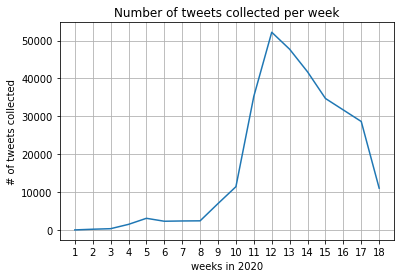

Total number of collected tweets: 313591


In [4]:
x = range(1,19)
plt.plot(x,weekly_data)
plt.xlabel('weeks in 2020')
plt.ylabel('# of tweets collected') 
plt.title('Number of tweets collected per week')
plt.grid(True)
plt.xticks(x)
plt.savefig('report/figures/collected-tweets.png', bbox_inches='tight')
plt.show()

print('Total number of collected tweets: {}'.format(sum(weekly_data)))

## Data Exploration

### Most Common Words

In [5]:
filtered = remove_list(tweets_fql, stoplist)
pd.DataFrame(filtered.most_common(10), index=range(1,11), columns=['words','# of times used'])

,words,# of times used
1,covid-19,250211
2,people,35223
3,cases,29825
4,health,26729
5,now,25382
6,new,25016
7,coronavirus,22177
8,pandemic,22046
9,just,18006
10,help,17587


### Most Common Words Wordcloud

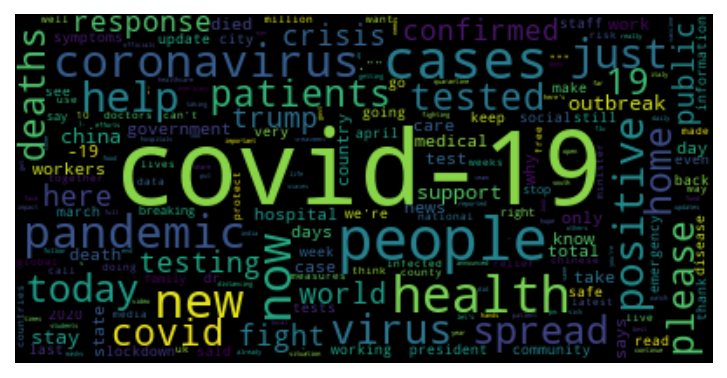

In [6]:
filtered = remove_list(tweets_fql, stoplist)
create_wordcloud(filtered)

### Most Common Hashtags
These are the most common hashtags for the whole period, excluding the common coronavirus hashtags.

In [7]:
hashtags_stoplist = ['#coronavirus', '#covid19', '#covid2019','#covid_19','#covid',
                     '#coronavid19','#coronavirusoutbreak','#coronaviruspandemic',
                     '#covid19pandemic','#covid__19']

filtered = remove_list(hashtags_fql, hashtags_stoplist)
pd.DataFrame(filtered.most_common(10), index=range(1,11), columns=['hashtags','# of times used'])

,hashtags,# of times used
1,#stayhome,2982
2,#china,2131
3,#stayathome,1814
4,#breaking,1711
5,#wuhan,1411
6,#coronaoutbreak,1323
7,#indiafightscorona,1255
8,#coronavirusupdate,1031
9,#lockdown,885
10,#corona,791


### Most Common Hashtags Wordcloud

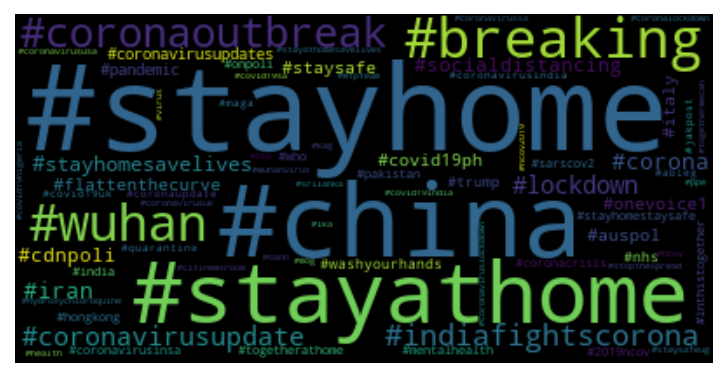

In [8]:
create_wordcloud(filtered)

### Most Common Words per Week

In [9]:
filtered = remove_list(tweetsPerWeek[10], stoplist)

most_common_str = [''] * len(tweetsPerWeek)
for i, t in enumerate(tweetsPerWeek):
    filtered = remove_list(t, stoplist)
    most_common = [w[0] for w in filtered.most_common(5)]
    most_common_str[i] = '{}, {}, {}, {}, {}'.format(most_common[0],most_common[1],most_common[2],most_common[3],most_common[4])
    
pd.DataFrame(most_common_str, index=range(1,len(tweetsPerWeek)+1), columns=['Most common words per week'])

,Most common words per week
1,"new, twitter, respiratory, viruses, ruled"
2,"new, china, novel, outbreak, chinese"
3,"china, new, novel, outbreak, cases"
4,"china, wuhan, cases, new, people"
5,"china, wuhan, people, outbreak, health"
6,"china, people, chinese, cases, hospital"
7,"covid-19, coronavirus, china, cases, virus"
8,"covid-19, cases, coronavirus, china, outbreak"
9,"covid-19, coronavirus, health, cases, people"
10,"covid-19, coronavirus, cases, people, health"


### Intersting Words During the Whole Period

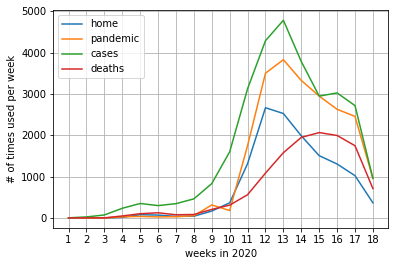

In [10]:
home = [t['home'] for t in tweetsPerWeek]
pandemic = [t['pandemic'] for t in tweetsPerWeek]
cases = [t['cases'] for t in tweetsPerWeek]
deaths = [t['deaths'] for t in tweetsPerWeek]

x = range(1,len(home)+1)
plt.plot(x,home,x,pandemic,x,cases,x,deaths)
plt.grid(True)
plt.ylabel('# of times used per week')
plt.xlabel('weeks in 2020')
plt.xticks(x)
plt.legend(['home','pandemic','cases','deaths'])
plt.savefig('report/figures/interesting-words-per-week.png', bbox_inches='tight')
plt.show()

### Interesting Hashtags During the Whole Period

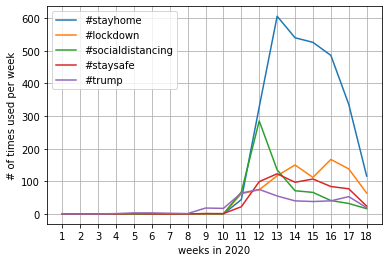

In [11]:
stayhome = [h['#stayhome'] for h in hashtagsPerWeek]
lockdown = [h['#lockdown'] for h in hashtagsPerWeek]
socialdistancing = [h['#socialdistancing'] for h in hashtagsPerWeek]
staysafe = [h['#staysafe'] for h in hashtagsPerWeek]
trump = [h['#trump'] for h in hashtagsPerWeek]

x = range(1,len(stayhome)+1)
plt.plot(x,stayhome,x,lockdown,x,socialdistancing,x,staysafe,x,trump)
plt.grid(True)
plt.ylabel('# of times used per week')
plt.xlabel('weeks in 2020')
plt.xticks(x)
plt.legend(['#stayhome','#lockdown','#socialdistancing','#staysafe','#trump'])
plt.savefig('report/figures/interesting-hashtags-per-week.png', bbox_inches='tight')
plt.show()

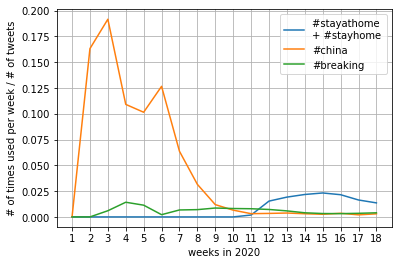

In [12]:
stayathome = [(h['#stayhome']+h['#stayathome'])/weekly_data[i] for i, h in enumerate(hashtagsPerWeek)]
china = [h['#china']/weekly_data[i] for i, h in enumerate(hashtagsPerWeek)]
breaking = [h['#breaking']/weekly_data[i] for i, h in enumerate(hashtagsPerWeek)]

x = range(1,len(stayathome)+1)
plt.plot(x,stayathome,x,china,x,breaking)
plt.grid(True)
plt.ylabel('# of times used per week / # of tweets')
plt.xlabel('weeks in 2020')
plt.xticks(x)
plt.legend(['#stayathome \n+ #stayhome','#china','#breaking'])
plt.savefig('report/figures/top-hashtags-density-per-week.png', bbox_inches='tight')
plt.show()

# Sentiment Analysis

## Define Sentiment Analysis Functions

In [13]:
def preprocess(text):
    hashtag_re = re.compile(r"#\w+")
    mention_re = re.compile(r"@\w+")
    url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
    p_text = hashtag_re.sub("",text)
    p_text = mention_re.sub("",p_text)
    p_text = url_re.sub("",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

def tokenise(text):
    tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
    return tokenise_re.findall(text)


class Document:
    def __init__(self):
        self.tokens_fql = Counter()
        self.pos_fql = Counter()
        self.pos_list = []
        self.num_tokens = 0
        self.text = ""
        
    def extract_features_from_text(self, text):
        self.text += text
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens)
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): 
        for text in texts:
            extract_features_from_text(text)
            
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): 
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)
            
def import_tweet(tweet):
    doc = Document()
    doc.extract_features_from_text(tweet)
    return doc

def get_tokens_fql(document):
    return document.tokens_fql

def get_pos_fql(document):
    return document.pos_fql

def read_list(file):
    with open(file, encoding="utf8") as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items


fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql


# Classifier results
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (4, 4)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, fmt="d", linewidths=.1, center=0)
    ax.set_ylim(len(cmdf)+0.5, -0.5)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

## Import Classification Data

In [14]:
classificationData = pd.read_csv('classification-data/tweets_annotation.csv')

tweets = [''] * len(classificationData)
labels2 = [0] * len(classificationData)
labels3 = [0] * len(classificationData)

#Two & three way classification data
for i, data in classificationData.iterrows():
    tweets[i] = data.Tweet
    if data.AverageAnnotation > 0:
        labels2[i] = 'optimistic'
    else:
        labels2[i] = 'pessimistic'
    
    if data.AverageAnnotation > 1:
        labels3[i] = 'optimistic'
    elif data.AverageAnnotation < -1:
        labels3[i] = 'pessimistic'
    else:
        labels3[i] = 'neutral'
        
corpus = []

for tweet in tweets:
    corpus.append(import_tweet(tweet))

## Three-way classification model

## Three-way Data Splitting

In [15]:
X = corpus
y = labels3

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

5980 1495
5980 1495


### Three-way Model Selection

In [16]:
model = Pipeline([ 
    ('union', FeatureUnion(
        transformer_list = [
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('tokens', Pipeline([
                ('processor', DocumentProcessor(process_method = get_tokens_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', None),
])

param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_pos_fql],
    'selector__k': [50, 100, 150, 500, 1000, 2500, 5000],
    'clf': [MultinomialNB(alpha=1, fit_prior=False), LogisticRegression(solver='liblinear', random_state=0),GradientBoostingClassifier()],
}



search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('word',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('processor',
                                                                                         DocumentProcessor(process_method=None)),
                                                                                        ('vectorizer',
                                                                                         DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                           

### Three-way Model Accuracy

Accuracy:  0.6408026755852843
              precision    recall  f1-score   support

     neutral       0.73      0.67      0.70       903
  optimistic       0.56      0.65      0.60       395
 pessimistic       0.45      0.47      0.46       197

    accuracy                           0.64      1495
   macro avg       0.58      0.60      0.59      1495
weighted avg       0.65      0.64      0.64      1495

[[608 191 104]
 [129 258   8]
 [ 94  11  92]]


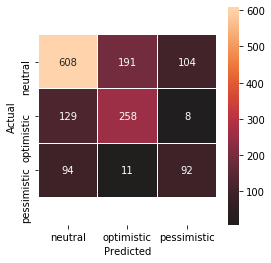

In [17]:
pd.DataFrame(search.cv_results_)
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

### Three-way Model Error Analysis

In [18]:
X_test_texts = [x.text for x in X_test]
df = pd.DataFrame(list(zip(X_test_texts,y_test,predictions)), columns=["Tweet", "Actual", "Predicted"])
pd.options.display.max_colwidth = 300
df.head(10)

,Tweet,Actual,Predicted
0,add a siastbadge before july 12 and be entered to win an ipad 2. it's that easy.,neutral,optimistic
1,@saviour_queen it was bound to happen eventually xd it /is/ bloody and violent. but i've seen way worse tbh,neutral,neutral
2,you spent your whole life looking for the truth. sometimes the truth just sucks.,pessimistic,pessimistic
3,my logic got fucked up that totally failed,neutral,pessimistic
4,kara could be such an amazing addition to the team. and instead. she's being reduced to... whatever this is.,optimistic,optimistic
5,#sagittarius tend to be so truthful that they will speak their minds during sex which could be a good or bad thing.,neutral,neutral
6,i always find the tick tock slogan rather creepy and threatening. but at the least the nats are giving fair warning,neutral,optimistic
7,@cfl_homeless @mustardseedoffl @helpwlove :we love and support what you do for our community:thank you!,optimistic,optimistic
8,@_dalejrbeard_ growing more and more tempting...,neutral,neutral
9,@jo_slaps_hoes 50 flavors of delicious milkshakes.. omg,optimistic,neutral


### Three-way Model Best Parameters

In [19]:
print(search.best_params_)

{'clf': MultinomialNB(alpha=1, class_prior=None, fit_prior=False), 'selector__k': 150, 'union__word__processor__process_method': <function get_pos_fql at 0x000001AAC6DE1AF8>}


### Save Three-way Model

In [20]:
dump(search, '3way-classifier.joblib')

['3way-classifier.joblib']

## Two-way Classification Model

### Two-way Data Splitting

In [21]:
X = corpus
y = labels2

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

5980 1495
5980 1495


### Two-way Model Selection

In [22]:
model = Pipeline([ 
    ('union', FeatureUnion(
        transformer_list = [
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('tokens', Pipeline([
                ('processor', DocumentProcessor(process_method = get_tokens_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', None),
])

param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_pos_fql],
    'selector__k': [50, 100, 150, 500, 1000, 2500, 5000],
    'clf': [MultinomialNB(alpha=1, fit_prior=False), LogisticRegression(solver='liblinear', random_state=0),GradientBoostingClassifier()],
}



search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('word',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('processor',
                                                                                         DocumentProcessor(process_method=None)),
                                                                                        ('vectorizer',
                                                                                         DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                           

### Two-way Model Accuracy

Accuracy:  0.7331103678929766
              precision    recall  f1-score   support

  optimistic       0.74      0.81      0.77       837
 pessimistic       0.73      0.63      0.68       658

    accuracy                           0.73      1495
   macro avg       0.73      0.72      0.72      1495
weighted avg       0.73      0.73      0.73      1495

[[681 156]
 [243 415]]


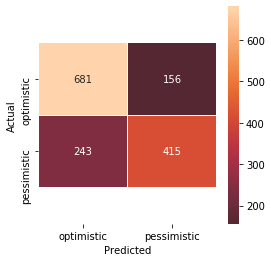

In [23]:
pd.DataFrame(search.cv_results_)
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

### Two-way Model Error Analysis

In [24]:
X_test_texts = [x.text for x in X_test]
df = pd.DataFrame(list(zip(X_test_texts,y_test,predictions)), columns=["Tweet", "Actual", "Predicted"])
pd.options.display.max_colwidth = 300
df.head(10)

,Tweet,Actual,Predicted
0,now. that kid's gonna grow up with better tech. do the same thing to her while she's tryna talk to him and he'll be there like yeah. ok,optimistic,pessimistic
1,having a serious relapse in my recovery and i only have six days until a level exams. nice timing rebecca :-),optimistic,pessimistic
2,wow just realized today is the official start of fall,optimistic,pessimistic
3,don't compromise what you want just to keep someone around. do what's best for you. even if it hurts. #stayheartless,optimistic,optimistic
4,it wasnt. a takeover. im pissed. it wasnt. a takeover. im pissed. it wasnt. a takeover. im pissed. it wasnt. a takeover. im pissed. it wasnt,pessimistic,pessimistic
5,know yourself better before other gives you their description.,optimistic,optimistic
6,wish i could have made it to @alexiskienlen's book launch. not only did i deliver a workshop. i returned home to a plumbing disaster.,pessimistic,optimistic
7,@sumirafiq lool i'm cooking for only you next wknd lover.,optimistic,optimistic
8,&amp; like the worst part is we're all going down our tl &amp; know exactly what eachother's tweets are about #fuckedup,pessimistic,pessimistic
9,i'm probably going crazy for the rest of my life. thanks.,pessimistic,optimistic


### Two-way Model Best Parameters

In [25]:
print(search.best_params_)

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'selector__k': 1000, 'union__word__processor__process_method': <function get_pos_fql at 0x000001AAC6DE1AF8>}


### Save Two-way Model

In [26]:
dump(search, '2way-classifier.joblib')

['2way-classifier.joblib']

## Optimism Prediction for Coronavirus Tweets

## Data Classification

In [27]:
classifier2 = load('2way-classifier.joblib')
classifier3 = load('3way-classifier.joblib')

optimism2 = []
optimism3 = []

tweets_path = 'top-tweets-data/tweets'
for i, file in enumerate(listdir(tweets_path)):
    file_path = join(tweets_path, file)
    if isfile(file_path):
        data = read_list(file_path)
        
        corpus = []
        for tweet in data:
            corpus.append(import_tweet(tweet))
        
        predictions3 = classifier3.predict(corpus)
        
        optimistic = len([i for i, v in enumerate(predictions3) if v=='optimistic'])
        pessimistic = len([i for i, v in enumerate(predictions3) if v=='pessimistic'])
        neutral = len([i for i, v in enumerate(predictions3) if v=='neutral'])
        
        optimism3.append([optimistic, pessimistic, neutral])
        
        
        
        predictions2 = classifier2.predict(corpus)
        
        optimistic = len([i for i, v in enumerate(predictions2) if v=='optimistic'])
        pessimistic = len([i for i, v in enumerate(predictions2) if v=='pessimistic'])
        
        optimism2.append([optimistic, pessimistic])
        
        

### Three-way Model Classification Results

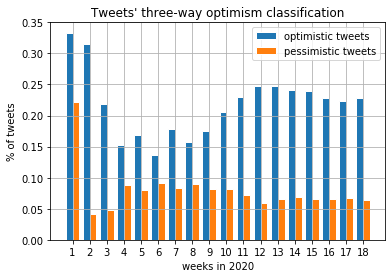

In [28]:
for t in optimism3:
    s = sum(t)
    t[0] /= s
    t[1] /= s
    t[2] /= s

optimism3 = np.array(optimism3)    
x = np.array(range(1,19))
barwidth = 0.4
plt.bar(x-barwidth/2,optimism3[:,0],width=barwidth, edgecolor='white', label='optimistic tweets')
plt.bar(x+barwidth/2,optimism3[:,1],width=barwidth, edgecolor='white', label='pessimistic tweets')
#plt.bar(x,optimism2[:,2])
plt.xticks(x)
plt.legend()
plt.xlabel('weeks in 2020')
plt.ylabel('% of tweets')
plt.title('Tweets\' three-way optimism classification')
plt.grid(True)
plt.savefig('report/figures/3way-optimism-classification.png')
plt.show()

### Two-way Model Classification Results

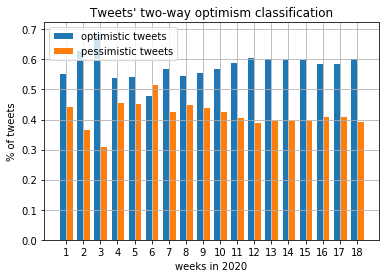

In [29]:
for t in optimism2:
    s = sum(t)
    t[0] /= s
    t[1] /= s

optimism2 = np.array(optimism2)    
x = np.array(range(1,19))
barwidth = 0.4
plt.bar(x-barwidth/2,optimism2[:,0],width=barwidth, edgecolor='white', label='optimistic tweets')
plt.bar(x+barwidth/2,optimism2[:,1],width=barwidth, edgecolor='white', label='pessimistic tweets')
#plt.bar(x,optimism2[:,2])
plt.xticks(x)
plt.legend()
plt.xlabel('weeks in 2020')
plt.ylabel('% of tweets')
plt.title('Tweets\' two-way optimism classification')
plt.grid(True)
plt.savefig('report/figures/2way-optimism-classification.png')
plt.show()